In [3]:
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import copy
import os 
import time
from matplotlib import colors as mcolors
import pandas as pd
from texttable import Texttable
import latextable

# Dose Optimization Problem of Cancer Neoantigen Vaccine

In [4]:
"Dynamical system of Neoantingen Vaccine for patients with melanoma "
"based on Marisabel et al (2021)"
def Patient_ratio_p(patient,h_p_low,h_p_up,objective,optimal):
    # patient, objective = 2, 2
    'Defining parameters of the model'
    "First step is to define the set of parameter and initial conditions per patient"
    
    "Vaccine parameters"
    dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
    temp_dose_p = 3*dose_p_all[patient-1]
    peptides = [13,17,14,14,20,20]
    ratio = (2/(0.3*peptides[patient-1]))
    'Conversion functions from pmol to mg'
    def masstomolar(mass,mw):
        'pmol = microgram / molecular weight (KD) '
        molar = (1e6*mass)/mw #'mass -> grams'
        return molar
    def molartomass(molar,mw):
        'gram = pmol * molecular weight (KD) /10^6'
        mass = (molar *mw)/1e6  #'molar -> picomole pmol'
        return mass
    'Peptide dose in mg by patient'
    peptide_mw = [32.68,42.49,38.33,36.03,54.12,53.66]
    alpha_p = 0.28 #1/day
    alpha_d = 0.5  #1/day
    V_sc = 4*0.1919 #L
    vac_time = 0.001 #Injection rate (20 secs per injection)
    rho = 1/vac_time
    
    "Dendritic Cells"
    Lambda = 3.75 #1/day
    delta_M = 0.33 #1/day
    r_D = 2.48 #1/day
    K_a = 6.64 #1e3 # mg/L 
    K_DC = 2.38*1e7 #cells
    V_E = 1e-14 #L
    
    " Antigen processing and presentation"
    alleles_j = [4,3,3,4,4,3] 
    alleles_k = [4,3,4,4,3,2]
    n = alleles_j[patient-1]
    m = alleles_k[patient-1]
    l = 4*(n+m) + 4
    
    N_A =6.02*(1e23) #1/mol
    alpha_Ep = 70 #1/day
    beta_p = 14.4 #1/day
    k_onj = 1.8144*(1e-2) #1/(pM*day) k_on1
    #K_DJ = 
    K_DJ_eff = [np.array([2022898.248, 2259523.473, 2167420.113, 1173316.913]),
                np.array([1484974.623,  2535151.868,    2284627.402]),
                np.array([2383016.796,  1526723.96, 1748749.88]),
                np.array([2022589.187,  3180789.851, 2759602.837,   2305265.682]),
                np.array([1663174.667,  1588701.641, 1749390.592,   1653025.941]),
                np.array([1927952.932,  1938657.991, 1253616.247])] # (sum(1/K_DJ[patient-1])**(-1))
    k_offj = k_onj*K_DJ_eff[patient-1]/1 # 1/day
    #K_DK = 
    K_DK_eff = [np.array([16081.17792,  271328.1446, 35471.5965,    33529.37879]),
                np.array([83978.51167,  31694.08875, 39710.93314]),
                np.array([23154.4359,   72622.70269,    4375.04084, 16491.62389]),
                np.array([19125.68472,  93663.04964,    53339.98855,    12503.98159]),
                np.array([96054.14771,  5452.233863,    8418.335798]),
                np.array([156840.5771,  96357.44993])]   
    #(sum(1/K_DK[patient-1])**(-1)) K_DJ and KD
    k_onk = 8.64*(1e-3) #1/(pM*day) k_on2
    k_offk = k_onk*K_DK_eff[patient-1]/1 #1/day
    
    "The values for the dissociation constant K_D,s were computed in the excel file "
    "patients_HLA_BA.xlsx were all the binding affinities for each peptide to MHC I/II "
    "were computed using NetMHCpan 4.0 and NetMHCIIpan 4.0"
    
    beta_M = 1.663 #1/day
    k_in = 14.4 #1/day
    k_ext = 28.8 #1/day
    beta_pM = 0.166 #1/day
    
    "T-cells "
    a = 5*(1e7) #cells
    a_1 = 1e3 #cells
    b_4 = 0.15 #1/day
    b_8 = 0.12 #1/day
    sigma_4 = 1.5 # 1/day
    sigma_8 = 3 #1/day
    K_TC = 8.57 * 1e11 #cells
    F_p4_all = np.array([0.006, 0.001, 0.001, 0.001, 0.003, 0.001])
    F_p8_all = np.array([0.007, 0.002, 0.006, 0.002, 0.002, 0.001]) 
    F_p4 = F_p4_all[patient-1]
    F_p8 = F_p8_all[patient-1]
    K_pM = 400
    c_all = [0.0156, 0.0084, 0.0448, 0.0056, 0.031, 5.55*(1e-5)] 
    c = c_all[patient-1] #1/day
    c_4_all = [0.04, 0.0105, 0.0487, 0.0467, 0.0327, 0.04224]
    c_4 = c_4_all[patient-1] #1/day
    c_8 = 6.5 * (1e-11) #1/day
    mu = 0.0029 #1/day
    mu_4 = 0.031 #1/day
    mu_8 = 0.022 #1/day
    rho_4 = 0.0265 #1/day
    rho_8 = 0.0509 #1/day
    
    " Tumor Cells "
    r = 0.004 #1/day
    K_T = 1.45 * (1e10) #cells
    d_all = np.array([0.068, 0.0196, 0.0649, 0.0617, 0.0525, 0.035])
    d = d_all[patient-1] #1/day
    lambda_all = np.array([0.978, 0.991, 1, 0.5, 0.8568, 0.6])
    lambdaa = lambda_all[patient-1]
    s = 0.0839  
    
    "Initial Conditions"
    p0 = 0#h_p  # h_p 
    A_d0 = 0#500 # 0.5 * 1e3
    D_I0 = 1*(1e7)
    D_M0 = 0
    p_E0 = 0
    
    M_jE0 = np.array([2, 2, 1, 3.5])*1e17/N_A 
    pM_jE0 = 0
    pM_j0 = 0
    M_j0 = 0
    def z0j(i):
        z0j = [M_jE0[i],pM_jE0,pM_j0,M_j0]
        return z0j
    temp_z0j = []
    for i in range(n):    
        temp_z0j = np.concatenate((temp_z0j,z0j(i)))
    z0j = temp_z0j
    
    M_kE0 = np.array([1, 1, 0.5, 0.5])*1e17/N_A
    pM_kE0 = 0
    pM_k0 = 0
    M_k0 = 0
    def z0k(i):
        z0k = [M_kE0[i],pM_kE0,pM_k0,M_k0]
        return z0k
    temp_z0k = []
    for i in range(m):    
        temp_z0k = np.concatenate((temp_z0k,z0k(i)))
    z0k = temp_z0k
    
    T0 = [1.375*(1e6), 1.139*(1e9), 1.177*(1e6), 1.493*(1e6),
          855265, 1.078*(1e9)]
    N_CD40 = 0.7*(5.38*(1e9))
    N_CD80 = 0.3*(5.39*(1e9))
    A_CD40 = np.array([1.43,1.43,1.43,1.43, 1.43, 1.43])*1e0*0.7
    A_CD80 = np.array([1.43, 1.43, 1.43, 1.43, 1.43, 1.43])*1e0*0.3
    
    z0 = [p0, A_d0, D_I0, D_M0, p_E0]    
    z0 = np.concatenate((z0,z0j,z0k))
    z_0 = np.concatenate((z0,[T0[patient-1], N_CD40, N_CD80, A_CD40[patient-1],
                             A_CD80[patient-1]]))#, A_CD40[patient-1]+A_CD80[patient-1]]))
    
    
    "Next we define the system of ODEs in Marisabel et al (2021)"
    def states(t,z):
        dotz = np.zeros(len(z))  #use np.zeros_like(z) for odeint  
    
        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point
    
        #some functions for later
    
        pM_I = N_A * (np.sum(np.fromiter((z[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A * (np.sum(np.fromiter((z[4*n + 7 + i*4] for i in range(m)),float))*1e-12)
    
        Psi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)
    
        "Vaccine peptide and adjuvant concentrations" 
        dotz[0] =  (rho)*h_p(t) - alpha_p*z[0]
        
        h_a = ratio*(1000)*molartomass(h_p(t), peptide_mw[patient-1]) 
        #     (a:p ratio) * (ml/L) * (mg/4ml) - > mg/4L
        dotz[1] =  (rho)*h_a - alpha_d*z[1]
    
        "Antigen-presenting cells: Dendritic cells "
        dotz[2] = Lambda*z[2]*(1- z[2]/K_DC) - r_D*(z[1])/(K_a+z[1]) * z[2]
        dotz[3] = r_D* (z[1])/(K_a+z[1]) * z[2] - delta_M*z[3]
    
        "Antigen processing and presentation by mature DCs"
        dotz[4] = (alpha_Ep*z[0]*V_E/V_sc 
                   - z[4]/V_E *(k_onj* np.sum(np.fromiter((z[5+i*4]  for i in range(n)), float))
                                + k_onk* np.sum(np.fromiter((z[4*n + 5 + i*4] for i in range(m)),float)))
                   + np.sum(np.fromiter((k_offj[i]*z[6+i*4] for i in range(n)),float))
                   + np.sum(np.fromiter((k_offk[i]*z[4*n + 6 + i*4] for i in range(m)),float)) 
                   - beta_p*z[4])
    
        for i in range(n):
            j = 5+i*4
            j1 = j+1
            j2 = j1+1
            j3 = j2+1
    
            dotz[j] = (beta_M*(z0[j] - z[j]) - k_onj * z[4]*(z[j]/V_E)
                       + k_offj[i]*z[j1] + k_in*z[j3])
            dotz[j1] = (k_onj* z[4]*(z[j]/V_E) - k_offj[i]*z[j1]
                        - beta_pM*z[j1] - k_ext*z[j1])
            dotz[j2] = k_ext*z[j1] - k_offj[i]*z[j2]
            dotz[j3] = k_offj[i]*z[j2] - k_in* z[j3]
    
        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1
    
            dotz[k] = (beta_M*(z0[k] - z[k]) - k_onk * z[4]*(z[k]/V_E)
                       + k_offk[i]*z[k1] + k_in*z[k3])
            dotz[k1] = (k_onk* z[4]*(z[k]/V_E) - k_offk[i]*z[k1] 
                        - beta_pM*z[k1] - k_ext*z[k1])
            dotz[k2] = k_ext*z[k1] - k_offk[i]*z[k2]
            dotz[k3] = k_offk[i]*z[k2] - k_in* z[k3]
    
        #l = 4*(n+m) + 4 # number of equations up to this point
    
        "Tumor Cells"
        D = d*((z[l+5]/z[l+1])**lambdaa)/(s+(z[l+5]/z[l+1])**lambdaa)
        #print(D)     
        dotz[l+1] = r*z[l+1]*(1-z[l+1]/K_T) - D*z[l+1]
    
        "Helper and Cytotoxic T cells"
        dotz[l+2] = (b_4*z[l+2]*(1-z[l+2]/(0.7*K_TC)) 
                     - sigma_4*F_p4*z[l+2]*Psi_4 - mu*z[l+2])
        dotz[l+3] = (b_8*z[l+3]*(1-z[l+3]/(0.3*K_TC)) 
                     - sigma_8*F_p8*z[l+3]*Psi_8 - mu*z[l+3])
        dotz[l+4] = (sigma_4*F_p4*z[l+2]*Psi_4 + rho_4*Phi_4 *z[l+4] 
                     + c_4*(z[l+1]/(a_1+z[l+1]))*z[l+4] - mu_4*z[l+4])
        dotz[l+5] = (c*(D**2*z[l+1]**2)/(a+D**2*z[l+1]**2)*z[l+5] + c_8*z[l+4]*z[l+1] 
                     + sigma_8*F_p8*z[l+3]*Psi_8 + rho_8*Phi_8 *z[l+5] - mu_8*z[l+5])
    
        return dotz
    
    def adjoints(t,lamb):
        z.sol = z
        dotlamb = np.zeros(len(lamb))  #use np.zeros_like(z) for odeint  
    
        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point
    
        #some functions for later
    
        pM_I = N_A*(np.sum(np.fromiter((z.sol(t)[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A*(np.sum(np.fromiter((z.sol(t)[4*n + 7 + i*4] for i in range(m)),float))*1e-12)
    
        Psi_4 = (z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)
    
        'Derivatives of Psi, Phi and pMn with respect to DM, NCDi, ACDi'
        dPsi_4dDM = ((F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) 
                    * (pM_II)/(pM_II+K_pM))
        dPsi_8dDM = ((F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])/((z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])**2) 
                    * (pM_I)/(pM_I+K_pM))
        dPhi_4dDM = ((F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) 
                     * (pM_II- K_pM)/(pM_II+K_pM))
        dPhi_8dDM = ((F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])/((z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])**2) 
                     * (pM_I- K_pM)/(pM_I+K_pM))
    
        dPsi_4dpMj = ((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPsi_4dpMk = ((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPhi_4dpMj = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPhi_4dpMk = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPsi_8dpMj = ((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPsi_8dpMk = ((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPhi_8dpMj = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPhi_8dpMk = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
    
        dPsi_4dNCD4 = -(F_p4*z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II)/(pM_II+K_pM)
        dPsi_8dNCD8 = -(F_p8*z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I)/(pM_I+K_pM)
        dPhi_4dNCD4 = -(F_p4*z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II-K_pM)/(pM_II+K_pM)
        dPhi_8dNCD8 = -(F_p8*z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I-K_pM)/(pM_I+K_pM)
    
        dPsi_4dACD4 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II)/(pM_II+K_pM)
        dPsi_8dACD8 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I)/(pM_I+K_pM)
        dPhi_4dACD4 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II-K_pM)/(pM_II+K_pM)
        dPhi_8dACD8 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I-K_pM)/(pM_I+K_pM)
    
        dDdT = -d*(((lambdaa*s*z.sol(t)[l+5])/(z.sol(t)[l+1]**2)*(z.sol(t)[l+5]/z.sol(t)[l+1])**(lambdaa-1))
                   /((s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)**2))
        dDdACD8 = d*(((lambdaa*s)/(z.sol(t)[l+1])*(z.sol(t)[l+5]/z.sol(t)[l+1])**(lambdaa-1))
                     /((s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)**2))
    
        "Vaccine peptide and adjuvant concentrations" 
        dotlamb[0] =  -(- alpha_p*lamb[0] + alpha_Ep*V_E/V_sc * lamb[4])
        dotlamb[1] =  -(- alpha_d*lamb[1]
                        - (r_D*K_a*z.sol(t)[2])/((K_a+z.sol(t)[1])**2)*(lamb[2] - lamb[3]))
    
    
        "Antigen-presenting cells: Dendritic cells "
        dotlamb[2] = -(Lambda*(1 - 2*z.sol(t)[2]/K_DC)*lamb[2] 
                       - (r_D*K_a)/(K_a+z.sol(t)[1]) * (lamb[2] - lamb[3]))
        dotlamb[3] = -(- delta_M*lamb[3] 
                       - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dDM) *(lamb[l+2]-lamb[l+4])
                       - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dDM) *(lamb[l+3]-lamb[l+5])
                       + rho_4*dPhi_4dDM *z.sol(t)[l+4] *lamb[l+4]
                       + rho_8*dPhi_8dDM *z.sol(t)[l+5] *lamb[l+5])
    
    
        "Antigen processing and presentation by mature DCs"
        dotlamb[4] = -(- ( np.sum(np.fromiter((k_onj/V_E*z.sol(t)[5+i*4] for i in range(n)), float)))*lamb[4]
                       - ( np.sum(np.fromiter((k_onj/V_E*z.sol(t)[5+i*4]*(lamb[5+i*4]-lamb[6+i*4]) 
                                                         for i in range(n)), float))) 
                       - ( np.sum(np.fromiter((k_onk/V_E*z.sol(t)[4*n+5+i*4] for i in range(m)), float)))*lamb[4]
                       - ( np.sum(np.fromiter((k_onk/V_E*z.sol(t)[4*n+5+i*4]*(lamb[4*n+5+i*4]-lamb[4*n+6+i*4])
                                                         for i in range(m)), float)))
                       - beta_p*lamb[4])
    
        for i in range(n):
            j = 5+i*4 #M_s^E
            j1 = j+1  #pM_s^E
            j2 = j1+1 #pM_s
            j3 = j2+1 #M_s
    
            dotlamb[j] = -(- k_onj *(z.sol(t)[4]/V_E)*(lamb[4]+lamb[j]-lamb[j1]) 
                           - beta_M * lamb[j])
            dotlamb[j1] = -( k_offj[i]*(lamb[4]+lamb[j]-lamb[j1]) 
                            - k_ext * (lamb[j1] - lamb[j2] ) - beta_pM*lamb[j1] )
            dotlamb[j2] = -(k_offj[i]*(lamb[j3] - lamb[j2]) 
                            - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dpMj)*(lamb[l+2]-lamb[l+4])
                            - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dpMj) *(lamb[l+3]-lamb[l+5])
                            + rho_4*dPhi_4dpMj *z.sol(t)[l+4] *lamb[l+4]
                            + rho_8*dPhi_8dpMj *z.sol(t)[l+5] *lamb[l+5])
            dotlamb[j3] =  -(k_in* (lamb[j]-lamb[j3]))
    
        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1
    
            dotlamb[k]  = -(- k_onk *(z.sol(t)[4]/V_E)*(lamb[4]+lamb[k]-lamb[k1]) 
                            - beta_M * lamb[j])
            dotlamb[k1] = -( k_offk[i]*(lamb[4]+lamb[k]-lamb[k1]) 
                            - k_ext * (lamb[k1] - lamb[k2] ) - beta_pM*lamb[k1] )
            dotlamb[k2] = -(k_offk[i]*(lamb[k3] - lamb[k2]) 
                            - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dpMk)*(lamb[l+2]-lamb[l+4])
                            - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dpMk) *(lamb[l+3]-lamb[l+5])
                            + rho_4*dPhi_4dpMk *z.sol(t)[l+4] *lamb[l+4]
                            + rho_8*dPhi_8dpMk *z.sol(t)[l+5] *lamb[l+5])
            dotlamb[k3] = -(k_in* (lamb[k]-lamb[k3]))
    
        #l = 4*(n+m) + 4 # number of equations up to this point
    
        "Tumor Cells"
        D = d*((z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)/(s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)
    
    
        dotlamb[l+1] = -(A + (r - 2*r*z.sol(t)[l+1]/K_T - D - z.sol(t)[l+1]*dDdT)*lamb[l+1] 
                         +(c_4*a_1/(a_1+z.sol(t)[l+1])**2*z.sol(t)[l+4])*lamb[l+4] 
                         +(c*(2*a*D**2*z.sol(t)[l+1])/((a+D**2 * z.sol(t)[l+1]**2)**2)*dDdT*z.sol(t)[l+5]
                           + c_8*z.sol(t)[l+4])*lamb[l+5])
        
        "Helper and Cytotoxic T cells"
    
        dotlamb[l+2] = -(b_4*(1-2*z.sol(t)[l+2]/(0.7*K_TC))*lamb[l+2] 
                         - sigma_4*F_p4*(Psi_4 + z.sol(t)[l+2]*dPsi_4dNCD4)*(lamb[l+2]-lamb[l+4])
                         + rho_4*dPhi_4dNCD4 *z.sol(t)[l+4]*lamb[l+4] - mu*lamb[l+2])
        dotlamb[l+3] = -( b_8*(1-2*z.sol(t)[l+3]/(0.3*K_TC))*lamb[l+3] 
                         - sigma_8*F_p8*(Psi_8 + z.sol(t)[l+3]*dPsi_8dNCD8)*(lamb[l+3]-lamb[l+5])
                         + rho_8*dPhi_8dNCD8 *z.sol(t)[l+5]*lamb[l+5] - mu*lamb[l+3])
        dotlamb[l+4] = -(A_4- sigma_4*F_p4*z.sol(t)[l+2]*dPsi_4dACD4*(lamb[l+2]-lamb[l+4])
                         + rho_4*(Phi_4 + z.sol(t)[l+4]*dPhi_4dACD4)*lamb[l+4]
                         + (c_4*(z.sol(t)[l+1]/(a_1+z.sol(t)[l+1])) - mu_4)*lamb[l+4] 
                         + c_8*z.sol(t)[l+1]*lamb[l+5])
        dotlamb[l+5] = -(A_8-(z.sol(t)[l+1]*dDdACD8)*lamb[l+1]
                         -(sigma_8*F_p8*z.sol(t)[l+3]*dPsi_8dACD8*(lamb[l+3]-lamb[l+5]))
                         +(c*(D**2*z.sol(t)[l+1]**2)/(a+D**2*z.sol(t)[l+1]**2)
                           + c*z.sol(t)[l+5]*2*a*D*z.sol(t)[l+1]**2/((a+D**2*z.sol(t)[l+1]**2)**2)*dDdACD8)*lamb[l+5]
                         + (rho_8*Phi_8 + rho_8*dPhi_8dACD8*z.sol(t)[l+5]-mu_8)*lamb[l+5])
    
        return dotlamb
    if optimal == 1:
        'Start a clock'
        start = time.time()
        
        'Forward-Backward Sweep Method for each subinterval'
        'timespan and ode-solver'
        t_f = 200
        steps = 50
        tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters
        
        tau_vac=[]
        for i in range(len(tau)):
            tau_vac.append(tau[i])
            tau_vac.append(tau[i]+vac_time)
        tau_vac.append(t_f)
        tau = tau_vac
        # tau.append(t_f)
        t_all=[]
        for i in range(len(tau)-1):
            t_all.append(np.linspace(tau[i],tau[i+1],steps)) 
        
        't variable'
        for i in range(len(t_all)):
            if i == 0:
                t = t_all[i]
            if i > 0: 
                t = np.append(t,t_all[i])
                
        N = len(t)
             
        'Initial Drug Concentration (Adjuvant+peptide cocktail)'
        NN = len(tau)-1
        h_p = []
        
        if h_p_up - h_p_low > 0:
            for i in range(NN):
                t_temp = len(t_all[i])
                if (tau[i+1]-tau[i]<1):
                    h_p_in = 0.5*(h_p_low+h_p_up)*np.ones(t_temp)
                    h_p = np.append(h_p, h_p_in)        
                    
                if (tau[i+1]-tau[i]>=1):
                    h_p_out = (0)*np.ones(t_temp) 
                    h_p = np.append(h_p, h_p_out)
        
        if h_p_up - h_p_low == 0:
            print('Yes!')
            for i in range(NN):
                t_temp = len(t_all[i])
                if (tau[i+1]-tau[i]<1):
                    h_p_in = 0.5*(h_p_low+h_p_up)*np.ones(t_temp)
                    h_p = np.append(h_p, h_p_in)        
                    
                if (tau[i+1]-tau[i]>=1):
                    h_p_out = (0)*np.ones(t_temp) 
                    h_p = np.append(h_p, h_p_out)
        #h_p = (2)*dose_p*np.ones(N)
        
        eqs = 5 + 4*(n+m) + 5 # eqs in the system    
        
        z = np.zeros([eqs,N])
        lamb = np.zeros([eqs,N])
        
        'Weight Parameters'
        
        if objective == 1:
            #[A, A_4,A_8, B] = set_weights_J1[patient-1]
            y = Patient_ratio_p(patient,temp_dose_p,temp_dose_p,2,0)
            [t1,statem,control_hpm, control_ham,rtime] = y
            [Tm, N_CD4m, N_CD8m, A_CD4m, A_CD8m] = statem[l+1:]
            A = 1/(integrate.trapezoid(Tm,t1))
            B = 1/(integrate.trapezoid(control_hpm**2,t1))
            #A = 3*A -> A = 1 and B = 1/3
            A, B = 1*A, (1/3)*B # -> J_T dominant
            # A, B = 0.5*A, 1*B -> J_V dominant 
            A_4, A_8 = 0, 0
            #set_weights_J1 = [A,A_4,A_8,B]
        
        if objective == 2:
            y = Patient_ratio_p(patient,temp_dose_p,temp_dose_p,2,0)
            [t1,statem,control_hpm, control_ham,rtime] = y
            [Tm, N_CD4m, N_CD8m, A_CD4m, A_CD8m] = statem[l+1:]
            A = 1/(integrate.trapezoid(Tm,t1))
            B = 1/(integrate.trapezoid((control_hpm)**2,t1))
            temp1 = integrate.trapezoid(A_CD4m,t1)
            A_4, A_8 = 1/temp1, 1/temp1
            #A, B, A_4, A_8 = 0.5*A, 1*B, 0.5*A_4, 0.5*A_8 #J_v dominant
            
        weights = [A, A_4,A_8, B]
        p = 2  # L^p error
        delta = 1e-2
        count = 0
        test = -1
        cmax = 25
        while (test<-(delta)) and (count<cmax):
            count = count + 1
            oldh_p = h_p.copy()
            oldz = z.copy()
            oldlamb = lamb.copy()
           
            h_p = interp1d(t, h_p,fill_value='extrapolate')    
            
            method = 'Radau' #'Radau' #<- solver for stiff system
        
            'Solve ODE system forward in time for each subinterval'
            sol_z = {}
            for i in range(NN):
                t_temp = t_all[i]
                if i == 0:
                    z0 = z_0
                z = solve_ivp(states,[tau[i], tau[i+1]],z0,
                              method = method,dense_output=True)
                z0 = z.sol(tau[i+1])
                sol_z[i] = z
            
            for i in range(NN):
                t_temp_z = t_all[i]
                if i == 0:
                    z = sol_z[i].sol(t_temp_z)
        
                if i>0:
                    z = np.append(z, sol_z[i].sol(t_temp_z),axis=1)
            z = interp1d(t, z,fill_value= 'extrapolate')
            print('pass states')
            
            'Solve Adjoint ODE system backward in time for each subinterval'
            sol_lamb = {}
            for i in range(NN):
                j = NN-i
                if j == NN:
                    lambtf = np.zeros(len(z0))
                    #lambtf[l+1] = 1
                    lambtf[l+1] = 0
                print(j,[tau[j-1],tau[j]])
                lamb = solve_ivp(adjoints,[tau[j],tau[j-1]],
                                 lambtf,method = method,dense_output=True)
                lambtf = lamb.sol(tau[j-1])
                sol_lamb[j] = lamb
            
            print('pass adjoints')
            
            for i in range(NN):
                t_temp_z = t_all[i]
                j = NN-i
                t_temp_lamb = t_all[j-1]
                if i == 0:
                    lamb = sol_lamb[j].sol(np.flip(t_temp_lamb))
        
                if i>0:
                    lamb = np.append(lamb, sol_lamb[j].sol(np.flip(t_temp_lamb)),axis=1)
            lamb = np.flip(lamb,1)
            z = z(t)    
            
            'Control Characterization (Update step)'
            u1 = np.zeros(N)
            
            for j in range(N):
                u_opt = -(rho*((lamb[0][j]+(ratio*1000*peptide_mw[patient-1]*1e-6*lamb[1][j]))/(2*B))) #quadratic
                u1[j] = min(h_p_up,max(h_p_low,u_opt))
              
            h_p = 0.5*(u1 + oldh_p)
            
            for i in range(len(tau)-1):
                for j in range(N):
                    if (tau[i]<=t[j]<=tau[i+1]) and (tau[i+1]-tau[i])>1:   
                        h_p[j] = 0
            print('pass controls')                      
            print(min(h_p), max(h_p))
            
            'Exit criteria are based on Lp errors, p=1 or p=2'
            temp_states=[]
            for j in range(len(z)):
                error = delta*np.linalg.norm(z[j],p) - np.linalg.norm((oldz[j] - z[j]),p)
                temp_states.append(error)
        
            temp_adjoints=[]
            for j in range(len(z)):
                error = delta*np.linalg.norm(lamb[j],p) - np.linalg.norm((oldlamb[j] - lamb[j]),p)
                temp_adjoints.append(error)
        
            temp_controls=[]
            error_hp = delta*np.linalg.norm(h_p,p) - np.linalg.norm((oldh_p - h_p),p)
            
            temp_controls.append(error_hp)
            
            test = [min(temp_states), min(temp_adjoints), min(temp_controls)]
            
            'Create a table for iteration and errors '
            if count == 1:
                table = [['Iteration','State Error','Adjoint Error',
                          'Control Error','Time']]
        
            test1 = []
            test1.append(count)
            for j in range(len(test)):
                test1.append(round(test[j],4))
                
            end = time.time()
            p_time = end - start        
            test1.append(round(p_time,2))
            table.append(test1)
            print(tabulate(table))
        
            test = np.min(test)
        
            print(count, round(test,3))
        
            pass
            
        'Creating table for overall subinterval features '
        end_temp = time.time()
        temp_time = str(round((end_temp - start),2))
        
        'Saving the solution for each subinterval'
        
        state = z
        adjoint = lamb
        control_hp = h_p
        
        'End the clock'
        end = time.time()
        rtime = end - start
        
        if count >=cmax:
            outcome = 'Not optimal'
        if test > -delta:
            outcome = 'Optimal'
             
        print('The control problem is '+outcome +'. It exited in approx. ' + str(round(rtime,3)) +' seconds')
        
        [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l+1:len(state)]
        control_ha = ratio*(1000)*molartomass(control_hp, peptide_mw[patient-1] )
        
        return [t,state,adjoint,control_hp,control_ha,rtime,
            weights, outcome]
    
    if optimal == 0:
        'Start a clock'
        start = time.time()
        
        'Forward-Backward Sweep Method for each subinterval'
        'timespan and ode-solver'
        t_f = 200
        steps = 50
        tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters
        
        tau_vac=[]
        for i in range(len(tau)):
            tau_vac.append(tau[i])
            tau_vac.append(tau[i]+vac_time)
        tau_vac.append(t_f)
        tau = tau_vac
        # tau.append(t_f)
        t_all=[]
        for i in range(len(tau)-1):
            t_all.append(np.linspace(tau[i],tau[i+1],steps)) 
        
        't variable'
        for i in range(len(t_all)):
            if i == 0:
                t = t_all[i]
            if i > 0: 
                t = np.append(t,t_all[i])
                
        N = len(t)
             
        'Initial Drug Concentration (Adjuvant+peptide cocktail)'
        NN = len(tau)-1
                
        h_p = 0.5*(h_p_low+h_p_up)*np.ones(N)
        for i in range(len(tau)-1):
            for j in range(N):
                if (tau[i]<=t[j]<=tau[i+1]) and (tau[i+1]-tau[i])>1:   
                    h_p[j] = 0
        'Saving the control'
        control_hp = np.copy(h_p)
    
        
        eqs = 5 + 4*(n+m) + 5 # eqs in the system    
        
        #z = np.zeros([eqs,N])
        
        h_p = interp1d(t, h_p,fill_value='extrapolate')    
        
        method = 'Radau' #'Radau' #<- solver for stiff system
    
        'Solve ODE system forward in time for each subinterval'
        sol_z = {}
        for i in range(NN):
            t_temp = t_all[i]
            if i == 0:
                z0 = z_0
            z = solve_ivp(states,[tau[i], tau[i+1]],z0,
                          method = method,dense_output=True)
            z0 = z.sol(tau[i+1])
            sol_z[i] = z
        
        for i in range(NN):
            t_temp_z = t_all[i]
            if i == 0:
                z = sol_z[i].sol(t_temp_z)
    
            if i>0:
                z = np.append(z, sol_z[i].sol(t_temp_z),axis=1)
        z = interp1d(t, z,fill_value= 'extrapolate')
        print('pass states')
        z = z(t)    
            
        'Saving the state solutions and control'
        state = z
        #control_hp = h_p(t)
        
        'End the clock'
        end = time.time()
        rtime = end - start
        
        [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l+1:len(state)]
        control_ha = ratio*(1000)*molartomass(control_hp, peptide_mw[patient-1] )
        
        return [t,state,control_hp,control_ha,rtime]

## Some useful functions

In [5]:
'lower bound close to 0 or 1/2 fold for peptides'
def y_p(x):
    if x == 1:
        y = j1patients_oc_p 
    if x == 2:
        y = j2patients_oc_p 
    return y

'Conversion functions from pmol to mg'
def masstomolar(mass,mw):
    'pmol = microgram / molecular weight (KD) '
    molar = (1e6*mass)/mw #'mass -> grams'
    return molar
def molartomass(molar,mw):
    'gram = pmol * molecular weight (KD) /10^6'
    mass = (molar *mw)/1e6  #'molar -> picomole pmol'
    return mass

'Diameter of the Tumor'
def diam(cells):
    diam = 2*(((cells*3)/(4*(np.pi)*0.7405*1e5))**(1/3))
    return diam

'Objective functions'
    
def J_1(A,B,T,control_hp,t):
    T_f = A*T[len(t)-1]
    J_T = A*integrate.trapezoid(T,t) + T_f
    J_v = B*integrate.trapezoid(control_hp**2,t) #+ integrate.trapezoid(control_hp,t) 
    
    J1 = J_T + J_v
    return  np.array([ J_T, J_v, T_f, J1])

def J_2(A,A_4,A_8,B,T,A_CD4,A_CD8,control_hp,t):
    T_f = A*T[len(t)-1]
    J_T = A*integrate.trapezoid(T,t) + T_f
    J_Tcell = (A_4*integrate.trapezoid(A_CD4,t) + 
               A_8*integrate.trapezoid(A_CD8,t))
    J_v = B*integrate.trapezoid(control_hp**2,t) #+ integrate.trapezoid(control_hp,t) 
    
    J2 = J_T + J_Tcell + J_v + T_f
    return np.array([ J_T, J_Tcell, J_v, T_f, J2])

'min fold'
def min_fold(my_dict,patient):
    a = []
    for key in my_dict.keys():
        if key[0] == patient:
            a.append(key[1])    
    min_fold = min(a)
    return(min_fold)

'Total peptide dose'
def total_peptides(patient,control_hp,t):
    rho = 1020
    peptide_mw = [32.68,42.49,38.33,36.03,54.12,53.66]
    mw = peptide_mw[patient-1]
    D = integrate.trapezoid(rho*control_hp,t) #+ integrate.trapezoid(control_hp,t) 
    D = molartomass(D, mw)
    return  D

# $\textit{In Silico}$ Results

In [6]:
"Load T cell longitudinal data of each patient"
t1 = np.array([0,19,83,111,139,167])
t2 = np.array([0,19,55,83,111,139,167])
t3 = np.array([0,19,55,83,111,139])
t_data = [t1,t2,t2,t2,t2,t3]
patients_data = [np.array([0,92.4,361.1,750,294.6,381.7]),
                 np.array([0,14.9,152.8,116.9,204,137.8,102.379]),
                 np.array([0,242.4,628.1,531.7,838.1,834.8,614.2]),
                 np.array([0,180.3,194.9,308.3,563.6,488.7,348.8]),
                 np.array([0,65.2,631.8,388.8,338.8,503.9,406.1]),
                 np.array([0,43.3,133.3,105.3,144,149.3])]                                        

pest = [np.array([1.43,1.32*1e8,5.2*1e8,1.07*1e9,4.2*1e8,5.5*1e8]),
        np.array([1.43,2.14*1e7,2.18*1e8,1.67*1e8,2.9*1e8,1.97*1e8,1.46*1e8]),
        np.array([1.43,3.5*1e8,9*1e8,7.6*1e8,1.2*1e9,1.19*1e9,8.8*1e8]),
        np.array([1.43,2.6*1e8,2.8*1e8,4.4*1e8,8.1*1e8,7*1e8,5*1e8]),
        np.array([1.43,9.3*1e7,9*1e8,5.6*1e8,4.8*1e8,7.2*1e8,5.8*1e8]),
        np.array([1.43,6.2*1e7,1.9*1e8,1.5*1e8,2.06*1e8,2.13*1e8])]
        
        
err = [np.array([0.21,0.20*1e8,0.8*1e8,0.16*1e9,0.6*1e8,0.8*1e8]),
       np.array([0.21,0.32*1e7,0.33*1e8,0.25*1e8,0.4*1e8,0.3*1e8,0.22*1e8]),
       np.array([0.21,0.5*1e8,1.3*1e8,1.1*1e8,0.18*1e9,0.18*1e9,1.3*1e8]),
       np.array([0.21,0.4*1e8,0.4*1e8,0.7*1e8,1.2*1e8,1*1e8,0.7*1e8]),
       np.array([0.21,1.4*1e7,1.4*1e8,0.8*1e8,0.7*1e8,1.1*1e8,0.9*1e8]),
       np.array([0.21,0.9*1e7,0.29*1e8,0.23*1e8,0.31*1e8,0.32*1e8])]

## Simulations without optimization

In [ ]:
dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
NN = [0,1,2,3,4,5]

'3 - clinical trial dose'
fold = 3
j0patients_3max={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_3max[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

'1 - clinical trial dose'
fold = 1
j0patients_max={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_max[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

'0.1 - clinical trial dose'
fold = 0.1
j0patients_tenth={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_tenth[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

'No - clinical trial dose'
fold = 0
j0patients_none={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_none[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

##  Solving dose-optimization problem in each subset $\mathcal{V_i}\subseteq \mathcal{V}$

In [12]:
'Defining empty dictionaries for J1 and J2' '***RUN ONLY ONCE***' 
j1patients_oc_p = {}
my_j1_ratio_dict = {}
my_j1_optimals = {}

j2patients_oc_p = {}
my_j2_ratio_dict = {}
my_j2_optimals = {}

In [ ]:
'Define target dose objective for J_1'
dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
NN = [0,1,2,3,4,5]
for i in NN: # patient = i + 1
    count = 0
    k1 = 0.07 #-> J_T ratio tolerance
    fold_set = np.linspace(3,0.5,11)
    n =len(fold_set)-1
    fold = fold_set[count]
    obj_func = 1
    dose_p = dose_p_all[i]
    
    'Solving first optimization in the whole set V'
    j1patients_oc_p[i+1] = Patient_ratio_p(i+1,0.1*dose_p,dose_p*fold,1,obj_func)
    opt_patients = y_p(obj_func)
    l = len(opt_patients[i+1][1]) 
    [t1,state,adjoint,control_hpc, control_hac,
     rtime, weights ,outcome] = opt_patients[i+1]
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = state[l-5:l]
    [A, A_4, A_8, B] = weights
    optimal = J_1(A, B, Tc, control_hpc, t1)[3]
    
    '1 - clinical trial dose -> Target dose' 
    l = len(j0patients_max[i+1][1])
    [t1,state,control_hpm, control_ham,rtime] = j0patients_max[i+1]
    [Tm, N_CD4m, N_CD8m, A_CD4m, A_CD8m] = state[l-5:l]
    target =  J_1(A,B,Tm,control_hpm,t1)[3]
    
    J_ratio = optimal/target
    
    save_vals = []
    save_vals.append([J_ratio,fold])
    my_j1_ratio_dict[i+1,fold] = opt_patients[i+1]
    while count < n:
        'Storing solutions that are better than target'
        if J_ratio < 1 + k1:
            my_j1_optimals[i+1,fold] = my_j1_ratio_dict[i+1,fold]
            print('Optimal is better than target')
            
        print(save_vals)
       
        fold = fold_set[count+1]
        
        'Solving optimization problem in the subsets V_i'            
        j1patients_oc_p[i+1] = Patient_ratio_p(i+1,0.1*dose_p,dose_p*fold,obj_func,1)
        opt_patients = y_p(obj_func)
        [t1,state,adjoint,control_hpc, control_hac,
         rtime, weights ,outcome] = opt_patients[i+1]
        [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = state[l-5:l]
        optimal = J_1(A, B, Tc, control_hpc, t1)[3]
        
        J_ratio = optimal/target
        
        save_vals.append([J_ratio,fold])
        
        'Storing solutions for all runs'
        my_j1_ratio_dict[i+1,fold] = opt_patients[i+1]
        
        print(J_ratio, count)
        count = count + 1 
    print(save_vals)

In [21]:
import pickle

# Your dictionary
#my_dict = my_j1_ratio_dict
############### Save the dictionary to a file #############
#with open("my_j1_ratio_dict_jupyter.pkl", "wb") as f:
#    pickle.dump(my_dict, f)

In [ ]:
'Define target dose objective for J_2'
dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
NN = [0,1,2,3,4,5]
for i in NN: # patient = i + 1
    count = 0
    k1 = 0.07 #-> J_T ratio tolerance
    fold_set = np.linspace(3,0.5,11)
    n =len(fold_set)-1
    fold = fold_set[count]
    obj_func = 2
    dose_p = dose_p_all[i]
    
    'Solving first optimization in the whole set V'
    j2patients_oc_p[i+1] = Patient_ratio_p(i+1,0.1*dose_p,dose_p*fold,obj_func,1)
    opt_patients = y_p(obj_func)
    l = len(opt_patients[i+1][1]) 
    [t1,state,adjoint,control_hpc, control_hac,
     rtime, weights ,outcome] = opt_patients[i+1]
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = state[l-5:l]
    [A, A_4, A_8, B] = weights
    optimal = J_2(A,A_4,A_8,B,Tc,A_CD4c,A_CD8c,control_hpc,t1)[4]
    
    '1 - clinical trial dose -> Target dose' 
    l = len(j0patients_max[i+1][1])
    [t1,state,control_hpm, control_ham,rtime] = j0patients_max[i+1]
    [Tm, N_CD4m, N_CD8m, A_CD4m, A_CD8m] = state[l-5:l]
    target =  J_2(A,A_4,A_8,B,Tm,A_CD4m,A_CD8m,control_hpm,t1)[4]
    
    J_ratio = optimal/target
    
    save_vals = []
    save_vals.append([J_ratio,fold])
    my_j2_ratio_dict[i+1,fold] = opt_patients[i+1]
    while count < n:
        'Storing solutions that are better than target'
        if J_ratio < 1 + k1:
            my_j2_optimals[i+1,fold] = my_j2_ratio_dict[i+1,fold]
            print('Optimal is better than target')
            
        print(save_vals)
       
        fold = fold_set[count+1]
        
        'Solving optimization problem in the subsets V_i'            
        j2patients_oc_p[i+1] = Patient_ratio_p(i+1,0.1*dose_p,dose_p*fold,obj_func,1)
        opt_patients = y_p(obj_func)
        [t1,state,adjoint,control_hpc, control_hac,
         rtime, weights ,outcome] = opt_patients[i+1]
        [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = state[l-5:l]
        optimal = J_2(A,A_4,A_8,B,Tc,A_CD4c,A_CD8c,control_hpc,t1)[4]
        
        J_ratio = optimal/target
        
        save_vals.append([J_ratio,fold])
        
        'Storing solutions for all runs'
        my_j2_ratio_dict[i+1,fold] = opt_patients[i+1]
        
        print(J_ratio, count)
        count = count + 1 
    print(save_vals)

In [23]:
import pickle

### Your dictionary
#my_dict = my_j2_ratio_dict

############### Save the dictionary to a file #############

#with open("my_j2_ratio_dict_jupyter.pkl", "wb") as f:
#    pickle.dump(my_dict, f)

In [8]:
import pickle

########### Load the dictionaries from the files ##############
with open("my_j1_ratio_dict_jupyter.pkl", "rb") as f:
    my_j1_ratio_dict = pickle.load(f)
    
with open("my_j2_ratio_dict_jupyter.pkl", "rb") as f:
    my_j2_ratio_dict = pickle.load(f)

## Selecting the most effective peptide dose for $J_1$ and $J_2$ compared to the clinical trial dose

In [9]:
'J and J_T ratio function for single patient and dose'
def J(my_dict,patient,fold,obj):
    opt_patients = my_dict
    l = len(opt_patients[patient,fold][1]) 
    [t1,state,adjoint,control_hpc, control_hac,
     rtime, weights ,outcome] = my_dict[patient,fold]
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = state[l-5:l]
    [A, A_4, A_8, B] = weights
    
    
    l = len(j0patients_max[patient][1])
    [t,state,control_hpm, control_ham,rtime] = j0patients_max[patient]
    [Tm, N_CD4m, N_CD8m, A_CD4m, A_CD8m] = state[l-5:l]
    
    if obj == 1:
        target = J_1(A,B,Tm,control_hpm,t1)
        optimal = J_1(A, B, Tc, control_hpc, t1)
        J_ratio = (optimal/target)[3]
        J_T_ratio = (optimal/target)[0]
    if obj == 2:
        target = J_2(A,A_4,A_8,B,Tm,A_CD4m,A_CD8m,control_hpm,t1)
        optimal = J_2(A,A_4,A_8,B,Tc,A_CD4c,A_CD8c,control_hpc,t1)
        J_ratio = (optimal/target)[4]
        J_T_ratio = (optimal/target)[0]
    return optimal, J_ratio, J_T_ratio

'J and J_T ratio function for single patient and all doses'
def J_ratio_opt(my_dict,patient,obj):
    js = []
    fold_list = []
    ratios = []
    J_T_ratios = []
    for key in sorted(my_dict.keys()):
        if key[0] == patient:
            fold = key[1]
            fold_list.append(fold)
            if obj == 1:
                j, ratio, J_T_ratio = J(my_dict,key[0],fold,obj)
                js.append(j)
                ratios.append(ratio)
                J_T_ratios.append(J_T_ratio)
            if obj == 2: 
                j, ratio, J_T_ratio = J(my_dict,key[0],fold,obj)
                js.append(j)            
                ratios.append(ratio)
                J_T_ratios.append(J_T_ratio)
    return js, fold_list, ratios, J_T_ratios

'Final dictionary with most effective peptide doses for all patients'
def my_dict_opt(my_dict,obj):
    my_dict_opt = {}
    set_patient = [1,2,3,4,5,6]
    for patient in set_patient:
        print(patient)
        js, fold_list, ratios, J_T_ratios = J_ratio_opt(my_dict,patient,obj)
        J_T_ratios1 = sorted([x for x in J_T_ratios if x < 1])
        a = 0.05        
        while len(J_T_ratios1) == 0:
            print(a)
            J_T_ratios1 = sorted([x for x in J_T_ratios if x < 1 + a])
            a = a + 0.05
        
        ratios1 = sorted([x for x in ratios if x < 1.05])
        count = 0
        index = J_T_ratios.index(J_T_ratios1[count])
        while ratios[index] not in ratios1:
            index = J_T_ratios.index(J_T_ratios1[count + 1])
            count = count + 1
            if count == len(J_T_ratios1)-1:
                break
        fold_opt = fold_list[index]
        my_dict_opt[patient] = my_dict[patient,fold_opt]
    return my_dict_opt

In [ ]:
'Storing optimal solutions for simulations'
opt_j1 = my_dict_opt(my_j1_ratio_dict,1)
opt_3 = opt_j1
opt_j2 = my_dict_opt(my_j2_ratio_dict,2)
opt_1 = opt_j2

## Optimal Peptide Concentrations for $J_1$ and $J_2$

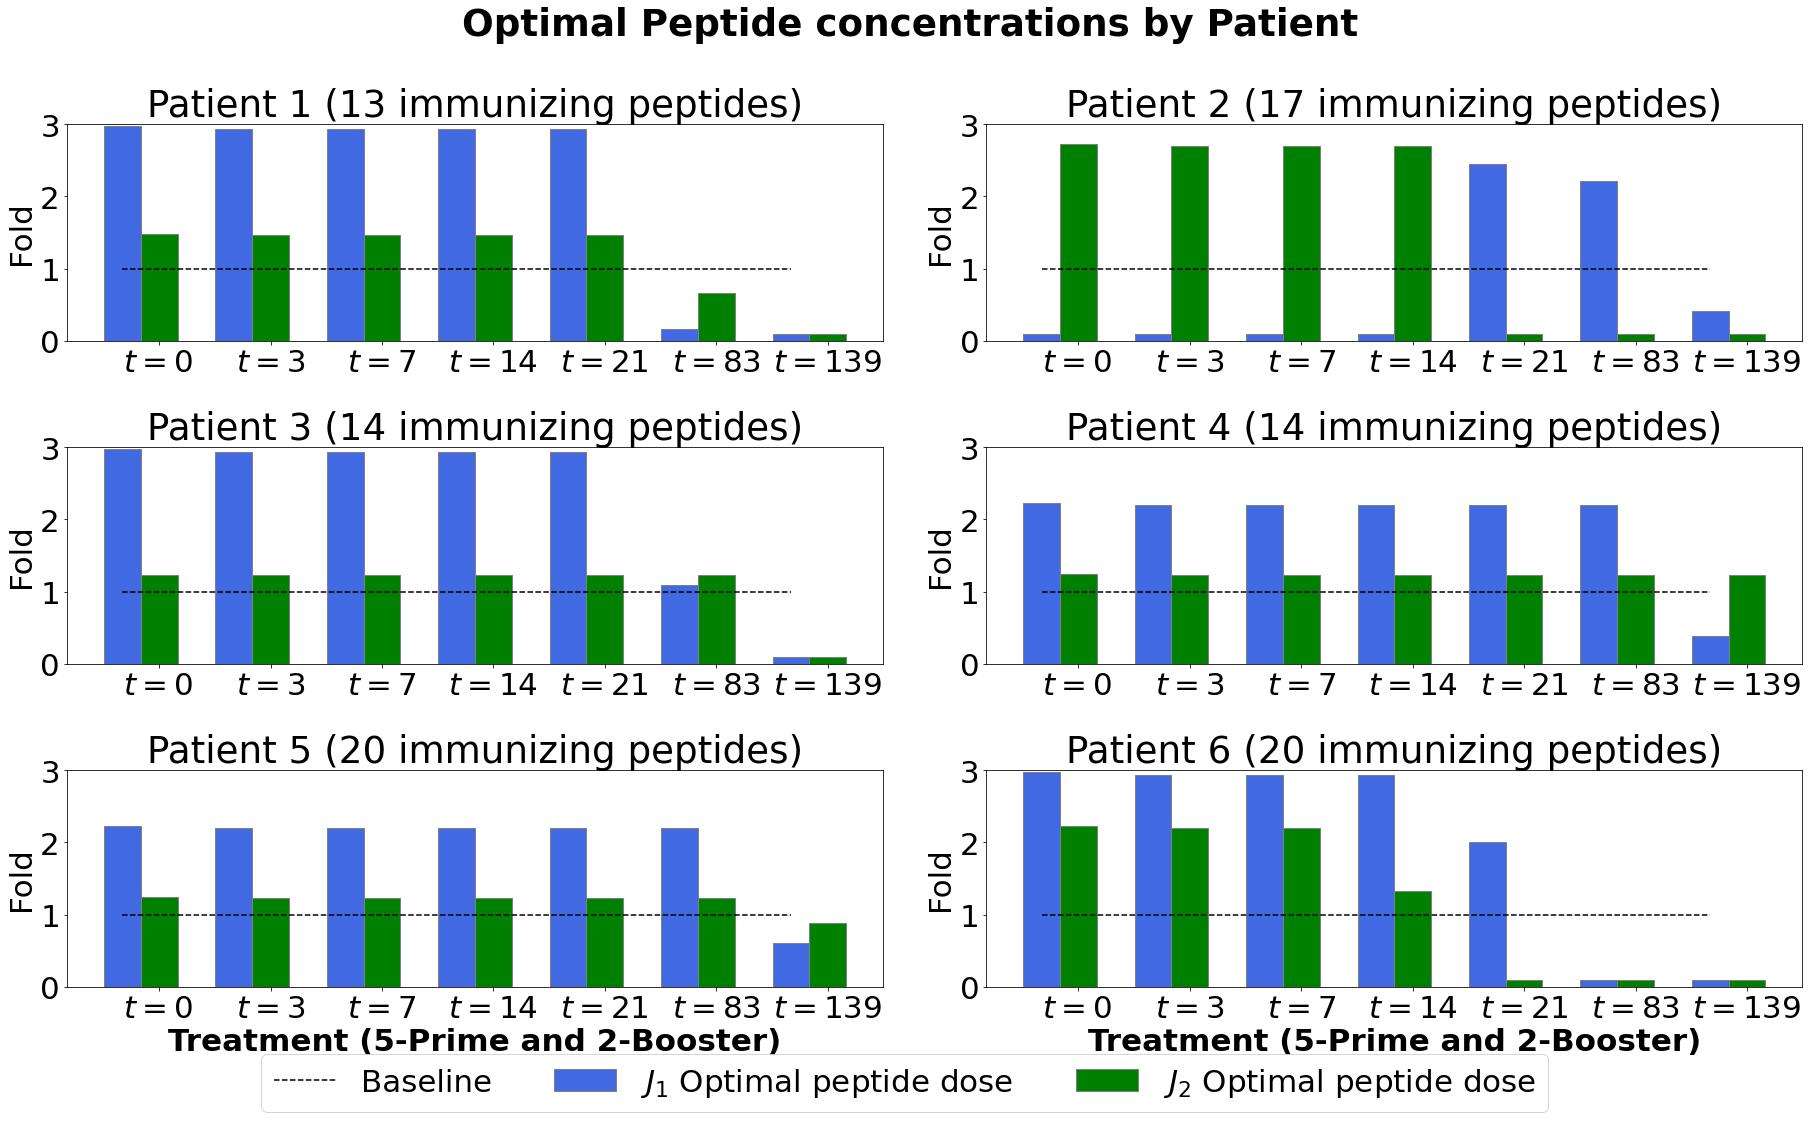

In [12]:
vac_time = 0.001 #Injection rate (20 secs per injection)
rho = 1/vac_time
tau = [0,3,7,14,21,83,139]
steps = 50
fold = 3
'Peptide dose in mg by patient'
peptide_mw = [32.68,42.49,38.33,36.03,54.12,53.66]

for i in range(6):
    [t1,state,adjoint,control_hp, control_ha,
     rtime,weights,outcome] = opt_3[i+1]
    [t,statec,adjointc,control_hpc, control_hac,
     rtimec, weights, outcome] = opt_1[i+1]
    if i == 0:
        j0peptide_dose = np.zeros((6,len(t1)))
        j0peptide_dosec = np.zeros((6,len(t)))

    for j in range(len(t1)):
        j0peptide_dose[i][j] = molartomass(control_hp[j],peptide_mw[i])

    for j in range(len(t)):
        j0peptide_dosec[i][j] = molartomass(control_hpc[j],peptide_mw[i])
        
j0peptide_doses = np.zeros([6,len(tau)])
j0peptide_dosesc = np.zeros([6,len(tau)])
for j in range(6):
    for i in range(len(tau)):
        j0peptide_doses[j][i] = integrate.trapezoid(rho*j0peptide_dose[j][2*i*steps:((2*i+1)*steps)+1],
                                                  t1[2*i*steps:((2*i+1)*steps)+1])
        j0peptide_dosesc[j][i] = integrate.trapezoid(rho*j0peptide_dosec[j][2*i*steps:((2*i+1)*steps)+1],
                                                  t[2*i*steps:((2*i+1)*steps)+1])
                                                  
barWidth = 0.33
max_dose = [3.9,5.1,4.2,4.2,6,6]
peptides = [13,17,14,14,20,20]

plt.rcParams.update({'font.size': 31,})
fig, axs = plt.subplots(3, 2,figsize=(26,16))
plt.suptitle('Optimal Peptide concentrations by Patient',fontweight ='bold')

# Set position of bar on X axis
br1 = np.arange(len(tau))
br2 = [x + barWidth for x in br1]

for i in range(len(axs.flat)):
    axs.flat[i].set_title('Patient '+str(i+1)+' ('+str(peptides[i])+' immunizing peptides)')
    axs.flat[i].bar(br1, j0peptide_doses[i]/(max_dose[i]) , color ='royalblue', width = barWidth,
            edgecolor ='grey', label ='Optimal peptide dose')
    axs.flat[i].hlines(y = 1, xmin= 0, xmax = 6, 
                       colors= 'k',linestyle = '--',label='Baseline')
    axs.flat[i].bar(br2, j0peptide_dosesc[i]/(max_dose[i]) , color ='g', width = barWidth,
            edgecolor ='grey', label ='Optimal peptide dose (refined)')
    axs.flat[i].set_ylim(0,fold)
    if i > 3:
        axs.flat[i].set_xlabel('Treatment (5-Prime and 2-Booster)', fontweight ='bold')
    axs.flat[i].set_ylabel('Fold')
    axs.flat[i].set_xticks([r + barWidth for r in range(len(tau))],
        ['$t=0$ ', '$t=3$', '$t=7$','$t=14$',
         '$t=21$', '$t=83$', '$t=139$' ])
   
labels = ['Baseline','$J_1$ Optimal peptide dose','$J_2$ Optimal peptide dose']

fig.legend(labels,loc='lower center',ncol=3) 
fig.tight_layout(rect=(0, .04, 1, 1))

if 3 in opt_3:
    j0peptide_doses1 = j0peptide_doses
if 1 in opt_1:
    j0peptide_doses2 = j0peptide_dosesc

## Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_1$ and $J_2$

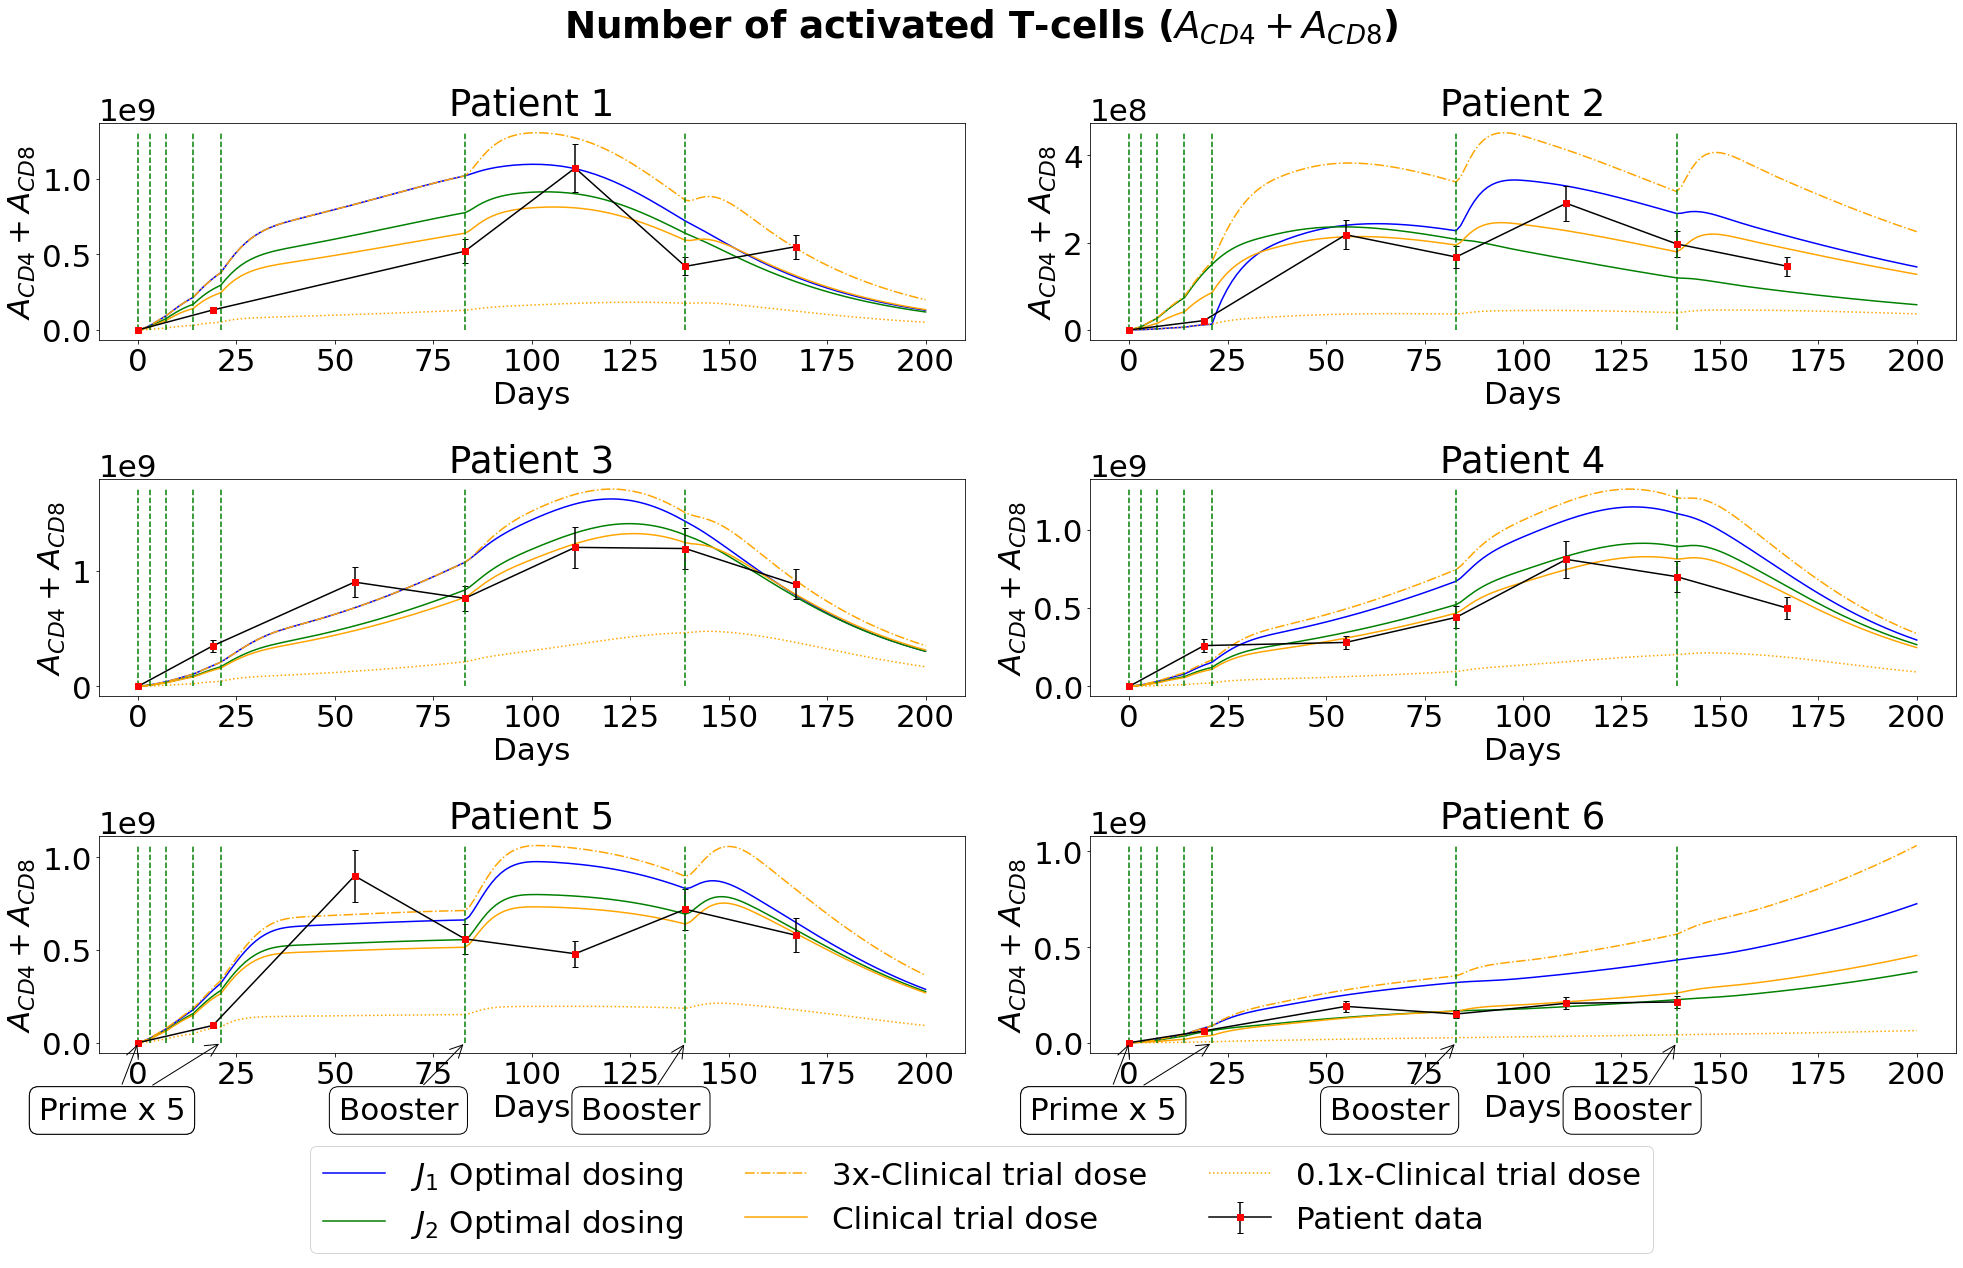

In [13]:
'Total number of activated T-cells (ACD4+ + ACD8) by patient'
tau = [0,3,7,14,21,83,139]
fig, axs = plt.subplots(3, 2,figsize=(28,18))
fig.suptitle('Number of activated T-cells ($A_{CD4} + A_{CD8}$)',fontweight ='bold')
for i in range(len(axs.flat)):
    l = len(opt_3[i+1][1]) 
    t = j0patients_max[i+1][0]
    t1 = opt_3[i+1][0]
    [To3, N_CD4o3, N_CD8o3, A_CD4o3, A_CD8o3] = opt_3[i+1][1][l-5:l]
    Total_cellso3 = A_CD4o3 + A_CD8o3
    [To1, N_CD4, N_CD8, A_CD4o1, A_CD8o1] = opt_1[i+1][1][l-5:l]
    Total_cellso1 = A_CD4o1 + A_CD8o1
    [Tc3, N_CD4c3, N_CD8c3, A_CD4c3, A_CD8c3] = j0patients_3max[i+1][1][l-5:l]
    Total_cellsc3 = A_CD4c3 + A_CD8c3
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = j0patients_max[i+1][1][l-5:l]
    Total_cellsc = A_CD4c + A_CD8c
    [T1, N_CD41, N_CD81, A_CD41, A_CD81] = j0patients_tenth[i+1][1][l-5:l]
    Total_cells1 = A_CD41 + A_CD81
    if i<4:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t1, Total_cellso3, color='blue', linewidth=1.5, label = '$J_1$ Optimal dosing')
        axs.flat[i].plot(t1, Total_cellso1, color='green', linewidth=1.5, label = '$J_2$ Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc3, linestyle='dashdot',color='orange', label = '3-Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, Total_cells1, linestyle='dotted',color='orange', label = '0.1-Clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Total_cellsc3), colors= 'g',linestyle = '--')
    else:
        axs.flat[i].set_title('Patient '+str(i+1))
        axs.flat[i].plot(t1, Total_cellso3, color='blue', linewidth=1.5 ,label = '$J_1$ Optimal dosing')
        axs.flat[i].plot(t1, Total_cellso1, color='green',linewidth=1.5, label = '$J_2$ Optimal dosing')
        axs.flat[i].plot(t, Total_cellsc3, linestyle='dashdot',color='orange', label = '3x-Clinical trial dose')
        axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
     
        axs.flat[i].plot(t, Total_cells1, linestyle='dotted',color='orange', label = '0.1x-Clinical trial dose')
        axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                             label= 'Patient '+ str(i+1)+' data',color = 'black',
                             capsize=3,marker = 's',mfc='red',mec='red')
        axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
        axs.flat[i].set_xlabel('Days')
    
        axs.flat[i].vlines(x = tau, ymin= 0,
                           ymax = max(Total_cellsc3),
                           colors= 'g',linestyle = '--')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')

handles = fig.gca().get_legend_handles_labels()[0]
labels = ['$J_1$ Optimal dosing', '$J_2$ Optimal dosing','3x-Clinical trial dose',
          'Clinical trial dose','0.1x-Clinical trial dose','Patient data']
          
fig.legend(handles,labels,loc='lower center',ncol=3)
          
fig.tight_layout(rect=(0, .08, 1, 1))

#  Diameter of Tumor by patient

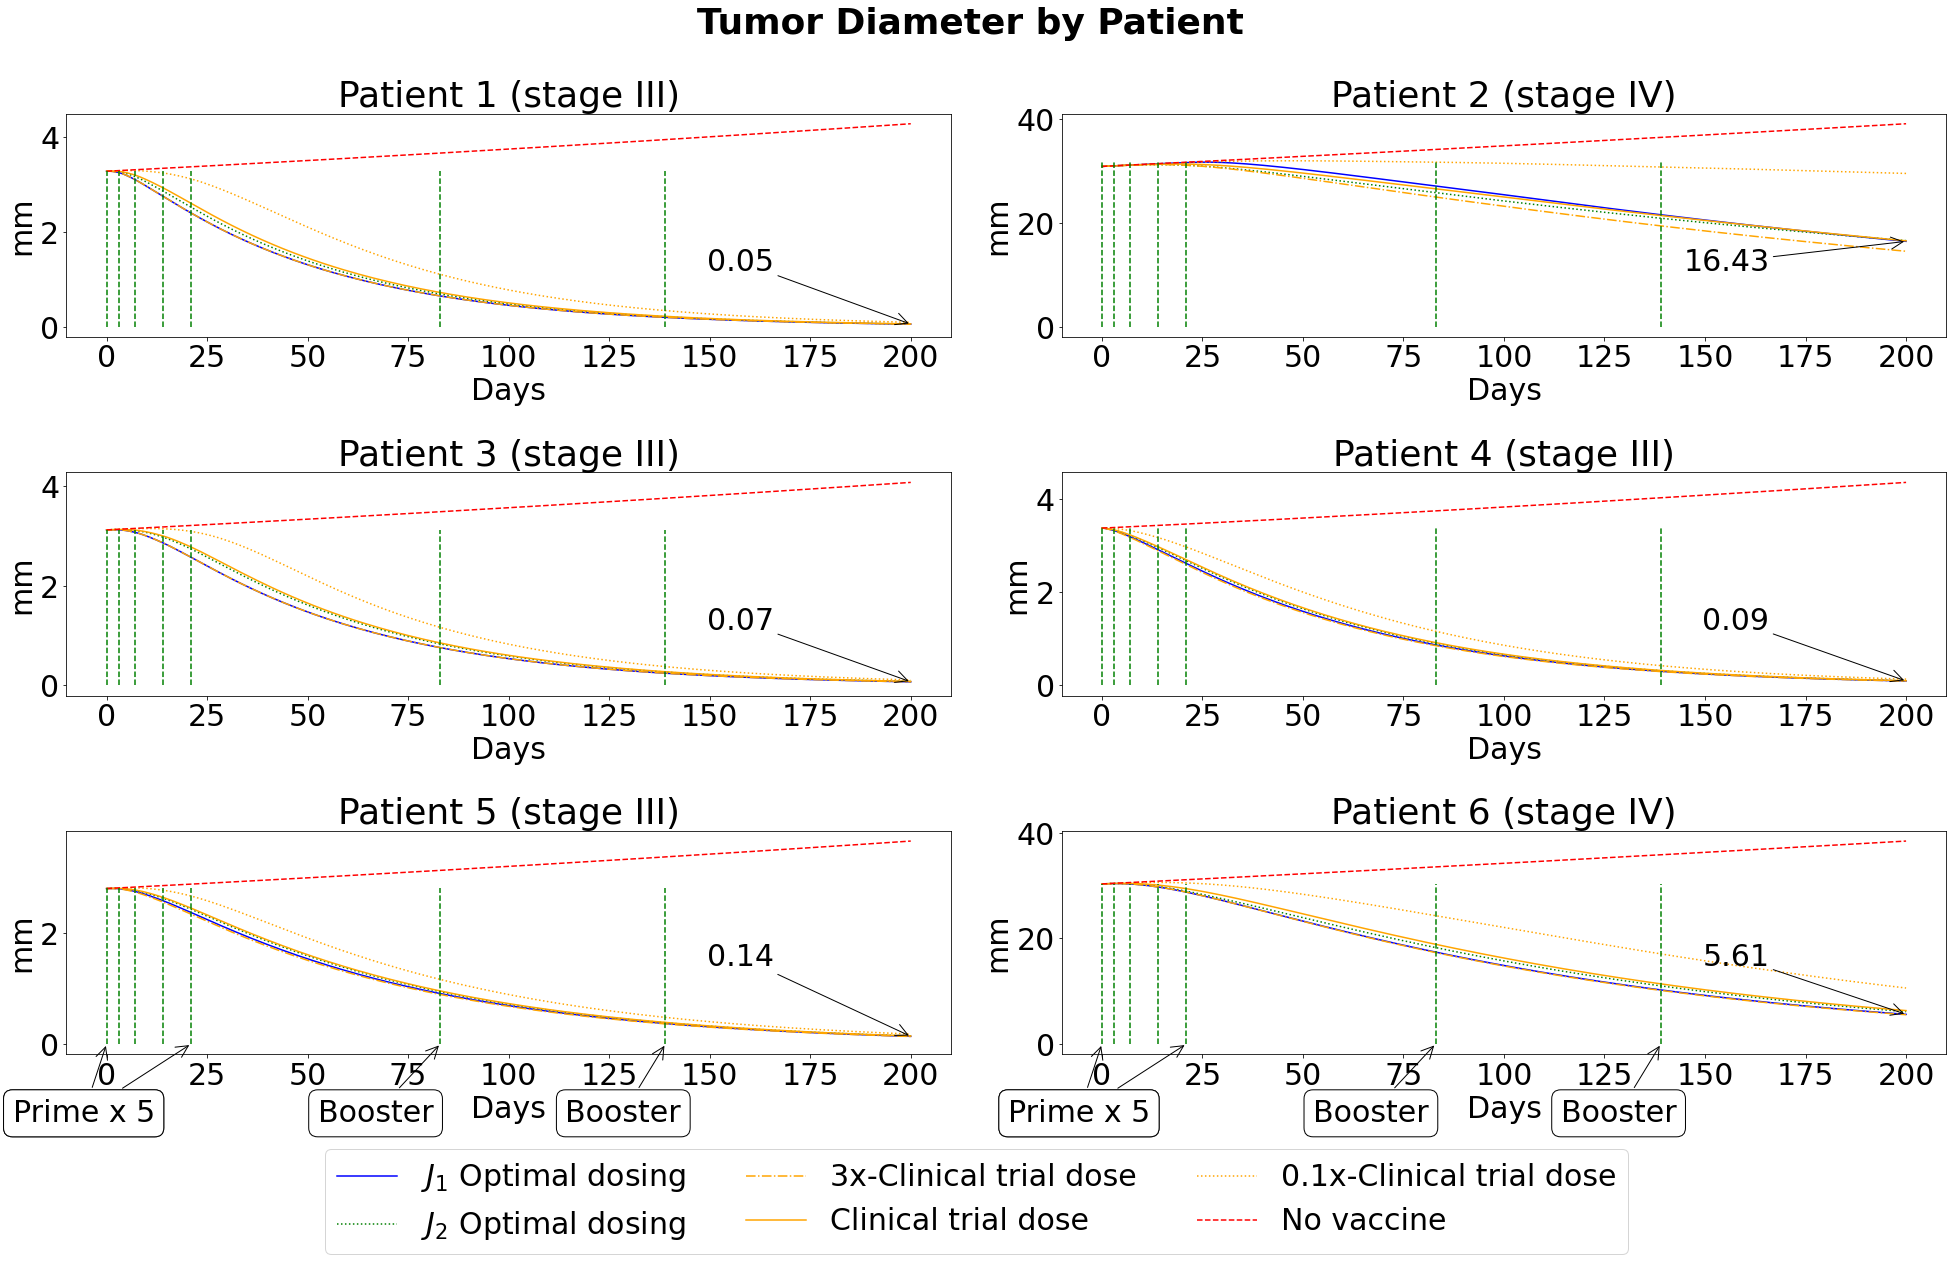

In [14]:
'Diameter of Tumor by patient'
tau = [0,3,7,14,21,83,139]
stage = ['III','IV','III','III','III','IV']
plt.rcParams.update({'font.size': 30,})
fig, axs = plt.subplots(3, 2,figsize=(28,18))
fig.suptitle('Tumor Diameter by Patient',fontweight ='bold')#  using  $J_'+str(obj_func)+'$')
for i in range(len(axs.flat)):
    l = len (opt_3[i+1][1]) 
    [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_3[i+1][1][l-5:l]
    [Tc3, N_CD4c3, N_CD8c3, A_CD4c3, A_CD8c3] = j0patients_3max[i+1][1][l-5:l]
    [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = j0patients_max[i+1][1][l-5:l]
    [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = opt_1[i+1][1][l-5:l]
    [T1, N_CD41, N_CD81, A_CD41, A_CD81] = j0patients_tenth[i+1][1][l-5:l]
    [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = j0patients_none[i+1][1][l-5:l]
    
    
    Tdiam = np.zeros(len(T))
    Tc3diam = np.zeros(len(Tc3))
    Tcdiam = np.zeros(len(Tc))
    Thdiam = np.zeros(len(Th))
    T1diam = np.zeros(len(T1))
    Tndiam = np.zeros(len(Tn))

    for j in range(len(t1)):
        Tdiam[j] = diam(T[j])
    for j in range(len(t)):
        Tc3diam[j] = diam(Tc3[j])
        Tcdiam[j] = diam(Tc[j])
        Thdiam[j] = diam(Th[j])
        T1diam[j] = diam(T1[j])
        Tndiam[j] = diam(Tn[j])
    

    if i<4:
        axs.flat[i].set_title('Patient '+str(i+1)+' (stage '+ str(stage[i])+')')
        axs.flat[i].plot(t1,Tdiam, color = 'blue', label = '$J_1$ Optimal dosing ',linewidth = 1.5)
        axs.flat[i].plot(t, Thdiam, linestyle=':' ,color = 'green', label = '$J_2$ Optimal dosing',linewidth = 1.5)
        axs.flat[i].plot(t, Tc3diam, linestyle='dashdot',color = 'orange', label = '3x-Clinical trial dose')
        axs.flat[i].plot(t, Tcdiam, color = 'orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, T1diam, linestyle='dotted',color = 'orange', label = '0.1x-Clinical trial dose')
        axs.flat[i].plot(t, Tndiam, linestyle='--',color = 'red', label = 'No vaccine')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].set_ylabel('mm')
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Tdiam), colors= 'g',linestyle = '--')
        b = str((round(Tdiam[len(t1)-1],2)))
        fT = Tdiam[len(t1)-1]
        axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                             xytext=(0.8, 0.4), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle='->'),
                             horizontalalignment='right', verticalalignment='top')
        
    else:
        axs.flat[i].set_title('Patient '+str(i+1)+' (stage '+ str(stage[i])+')')
        axs.flat[i].plot(t1,Tdiam, color = 'blue', label = '$J_1$ Optimal dosing',linewidth = 1.5)
        axs.flat[i].plot(t, Thdiam, linestyle=':' ,color = 'green', label = '$J_2$ Optimal dosing',linewidth = 1.5)
        axs.flat[i].plot(t, Tc3diam, linestyle='dashdot',color = 'orange', label = '3x-Clinical trial dose')
        axs.flat[i].plot(t, Tcdiam, color = 'orange', label = 'Clinical trial dose')
        axs.flat[i].plot(t, T1diam, linestyle='dotted',color = 'orange', label = '0.1x-Clinical trial dose')
        axs.flat[i].plot(t, Tndiam, linestyle='--',color = 'red', label = 'No vaccine')
        axs.flat[i].set_xlabel('Days')
        axs.flat[i].set_ylabel('mm')
        
        axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Tdiam), colors= 'g',linestyle = '--')
        b = str((round(Tdiam[len(t1)-1],2)))
        fT = Tdiam[len(t1)-1]
        axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                             xytext=(0.8, 0.5), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle='->'),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                             xytext=(0.1, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                             xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
        axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                             xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round", fc="w"),
                             horizontalalignment='right', verticalalignment='top')
handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=3)
        
fig.tight_layout(rect=(0, .08, 1, 1))

## Clinical benefit of the optimal vaccine dose

In [15]:
'All ratios'
def heat_map(table):
    matrix = np.array(table)
    columns = list(matrix[0][1:])
    index = list(matrix[1:,0])
    matrix = np.array(table[1:])
    matrix = matrix[0:,1:]
    
    # Create a DataFrame from the matrix
    df = pd.DataFrame(matrix, columns=columns, index=index)
    
    # Create a mask for values greater than 1
    mask = df > 1
    
    # Use seaborn to create a heatmap-like plot
    plt.figure(figsize=(20, 10))
    sns.heatmap(mask, cmap=["green", "red"], cbar=False, annot=df, fmt=".2f", linewidths=0.8)
    if 'J' in columns[1]:
        plt.title("Overall and individual ratios for $J_"+str(obj_func)+"$")
    if 'D' in columns[1]:
        plt.title("$D$-ratios for $J_"+str(obj_func)+"$")
    
set_patient = [0,1,2,3,4,5]

'Create a table for J_T, J_T-cell and D ratios'

for obj_func, opt_patients in [[1,opt_j1],[2, opt_j2]]:
    if obj_func in [1,3]:
        table = [['Patient_ID','$J_T(opt)/J_T(1)$','$D(opt)/D(1)$','$J_1(opt)/J_1(1)$']]
    if obj_func in [2,4]:
        table = [['Patient_ID','$J_T(opt)/J_T(1)$','$J_{T-cell}(opt)/J_{T-cell}(1)$',
                  '$D(opt)/D(1)$','$J_2(opt)/J_2(1)$']]

    for i in set_patient:
        l = len(opt_patients[i+1][1]) 
        [t1,state,adjoint,control_hpc, control_hac,
          rtime, weights ,outcome] =  opt_patients[i+1]
        [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = state[l-5:l]

        [A, A_4, A_8, B] = weights

        [t,state,control_hpm, control_ham,rtime] = j0patients_max[i+1]
        [Tm, N_CD4m, N_CD8m, A_CD4m, A_CD8m] = state[l-5:l]

        if obj_func in [1, 3]:
            value_0 = i+1
            value = []
            value.append(value_0)
            for j1 in [0,3]:
                temp_1 = J_1(A,B,Tc,control_hpc,t1)
                temp_2 = J_1(A,B,Tm,control_hpm,t)
                value_temp = (temp_1/temp_2)[j1]
                value.append(value_temp)
                if j1 == 0:    
                    value_2 = total_peptides(i+1,control_hpc,t)/ total_peptides(i+1,control_hpm,t)
                    value.append(value_2)
            for i in range(len(value)):
                if value[i] > 1:
                    value[i] = round(value[i],2)
                else: 
                    value[i] = round(value[i],2)
            table.append([val for val in value])

        if obj_func in [2, 4]:
            value_0 = i+1
            value = []
            value.append(value_0)
            for j2 in [0,1,4]:
                temp_1 = J_2(A,A_4,A_8,B,Tc,A_CD4c,A_CD8c,control_hpc,t1)
                temp_2 = J_2(A,A_4,A_8,B,Tm,A_CD4m,A_CD8m,control_hpm,t)
                value_temp = (temp_1/temp_2)[j2]
                value.append(value_temp)
                if j2 == 1:
                    value_2 = total_peptides(i+1,control_hpc,t)/ total_peptides(i+1,control_hpm,t)
                    value.append(value_2)

            table.append([round(val,2) for val in value])
    #heat_map(table)
    print(tabulate(table))

----------  -----------------  -------------  -----------------
Patient_ID  $J_T(opt)/J_T(1)$  $D(opt)/D(1)$  $J_1(opt)/J_1(1)$
1           0.85               2.18           1.02
2           1.04               0.8            1.06
3           0.84               2.32           1.02
4           0.93               1.98           1.04
5           0.92               2.02           1.03
6           0.88               2.04           1.04
----------  -----------------  -------------  -----------------
----------  -----------------  -------------------------------  -------------  -----------------
Patient_ID  $J_T(opt)/J_T(1)$  $J_{T-cell}(opt)/J_{T-cell}(1)$  $D(opt)/D(1)$  $J_2(opt)/J_2(1)$
1           0.94               1.11                             1.18           1.03
2           0.95               0.82                             1.62           1.01
3           0.97               1.05                             1.09           1.02
4           0.98               1.1                      

## Table with optimal peptide and adjuvant concentrations in Supplemental Information material

In [18]:
'Table with optimal peptide and adjuvant concentrations in Supplemental Information material'
for j_peptide_doses in [j0peptide_doses1, j0peptide_doses2]:
    for patient in [1,2,3,4,5,6]:
        
        'Adjuvant-Peptide dose in mg/4ml by patient'
        
        peptides = [13,17,14,14,20,20]
        ratio = (2/(0.3*peptides[patient-1]))
        vaccine_table = []
        vaccine_table =[[' Patient '+str(patient), 'Day 0', 'Day 3', 'Day 7', 'Day 14',
                         'Day 21', 'Day 83', 'Day 139']]
        pep = []
        adj = []
        pep = ['Peptide (mg/4ml)']
        adj = ['Adjuvant (mg/4ml)']
        for i in range(len(j_peptide_doses[patient-1])):
            pep.append(np.round(j_peptide_doses[patient-1][i],2))
            adj.append(np.round(ratio*j_peptide_doses[patient-1][i],2))

        vaccine_table.append(pep)
        vaccine_table.append(adj)

        table = Texttable()
        table.set_cols_align(["c"] * 8)
        table.set_deco(Texttable.HEADER | Texttable.VLINES)
        table.add_rows(vaccine_table)
        print(table.draw())

    Patient 1    | Day 0  | Day 3  | Day 7  | Day 14 | Day 21 | Day 83 | Day 139
=================+========+========+========+========+========+========+========
Peptide (mg/4ml) | 11.580 | 11.460 | 11.460 | 11.460 | 11.460 | 0.660  |  0.380 
    Adjuvant     | 5.940  | 5.880  | 5.880  | 5.880  | 5.880  | 0.340  |  0.200 
    (mg/4ml)     |        |        |        |        |        |        |        
    Patient 2     | Day 0 | Day 3 | Day 7 | Day 14 | Day 21 | Day 83 | Day 139
==================+=======+=======+=======+========+========+========+========
Peptide (mg/4ml)  | 0.510 | 0.500 | 0.500 | 0.500  | 12.490 | 11.300 |  2.100 
Adjuvant (mg/4ml) | 0.200 | 0.200 | 0.200 | 0.200  | 4.900  | 4.430  |  0.820 
    Patient 3    | Day 0  | Day 3  | Day 7  | Day 14 | Day 21 | Day 83 | Day 139
=================+========+========+========+========+========+========+========
Peptide (mg/4ml) | 12.470 | 12.340 | 12.340 | 12.340 | 12.340 | 4.590  |  0.410 
    Adjuvant     | 5.940  | 5.880  |